# <span style="color:green"><center> Gráficas de las estaciones meteorológicas </center></span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin

In [2]:
pcp_col = pd.read_excel('/home/fm/Downloads/pcp_col.xlsx')
#pcp_col = pcp_col.melt(id_vars = ['ID', 'X', 'Y'], var_name = 'Fecha', value_name = 'Valor').pivot_table('Valor', ['Fecha'], 'ID')
pcp_col['geometry'] = gpd.points_from_xy(pcp_col['X'], pcp_col['Y'])
gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_pcp_col.head()
#gdf_pcp_col = gpd.GeoDataFrame(pcp_col[['ID', 'X', 'Y']])

,ID,geometry
0,17015010,POINT (-81.70389 12.58694)
1,17025020,POINT (-81.35000 13.35000)
2,15015050,POINT (-74.22889 11.12833)
3,14015080,POINT (-75.51603 10.44725)
4,29045190,POINT (-74.77978 10.88334)


In [3]:
tmed_col = pd.read_excel('/home/fm/Downloads/tmed_col2.xlsx', sheet_name= 'tmed_col')
tmed_col['geometry'] = gpd.points_from_xy(tmed_col['X'], tmed_col['Y'])
gdf_tmed_col = gpd.GeoDataFrame(tmed_col[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_tmed_col.head()

,ID,geometry
0,11045010,POINT (-76.64386 5.69056)
1,11115020,POINT (-76.02972 6.75806)
2,12015020,POINT (-76.65139 7.82611)
3,12015070,POINT (-76.71783 7.81667)
4,12045020,POINT (-76.22550 9.07217)


In [4]:
gdf_pcp_tmed  = gdf_pcp_col.merge(gdf_tmed_col, how="outer", on='geometry', indicator=True)
gdf_pcp_tmed['met'] = np.where(gdf_pcp_tmed['_merge'] == 'left_only', 'precipitación', np.where(gdf_pcp_tmed['_merge'] == 'both', 'precipitación y temperatura', 'temperatura'))
gdf_pcp_tmed.groupby('met')['met'].count()

met
precipitación                  648
precipitación y temperatura    198
temperatura                     10
Name: met, dtype: int64

In [5]:
gdf_pcp_col.dtypes

ID             int64
geometry    geometry
dtype: object

In [6]:
# https://geoportal.igac.gov.co/contenido/datos-abiertos-cartografia-y-geografia
shp_depto = gpd.read_file('Departamentos202208_shp/Depto.shp')
shp_depto_4326 = shp_depto.to_crs("EPSG:4326")
shp_depto_4326["perimetro"] = shp_depto_4326.boundary

In [7]:
shp_join_gdf = sjoin(gdf_pcp_tmed, shp_depto_4326)
shp_join_gdf.head()

,ID_x,geometry,ID_y,_merge,met,index_right,DeCodigo,DeNombre,DeArea,DeNorma,SHAPE_Leng,SHAPE_Area,perimetro
0,17015010.0,POINT (-81.70389 12.58694),17015010.0,both,precipitación y temperatura,26,88,San Andrés Providencia y Santa Catalina,49.888768,Constitución Política de Colombia 1991,7.168404e+04,4.988877e+07,"MULTILINESTRING ((-81.70394 12.59485, -81.7039..."
2,15015050.0,POINT (-74.22889 11.12833),15015050.0,both,precipitación y temperatura,14,47,Magdalena,23109.484170,Constitución Política de Colombia 1886,1.180694e+06,2.310948e+10,"LINESTRING (-74.04165 11.34162, -74.04154 11.3..."
79,29060560.0,POINT (-74.17794 10.38444),NaN,left_only,precipitación,14,47,Magdalena,23109.484170,Constitución Política de Colombia 1886,1.180694e+06,2.310948e+10,"LINESTRING (-74.04165 11.34162, -74.04154 11.3..."
88,29060200.0,POINT (-74.18697 10.54067),NaN,left_only,precipitación,14,47,Magdalena,23109.484170,Constitución Política de Colombia 1886,1.180694e+06,2.310948e+10,"LINESTRING (-74.04165 11.34162, -74.04154 11.3..."
92,29060040.0,POINT (-74.18222 10.52436),NaN,left_only,precipitación,14,47,Magdalena,23109.484170,Constitución Política de Colombia 1886,1.180694e+06,2.310948e+10,"LINESTRING (-74.04165 11.34162, -74.04154 11.3..."


<AxesSubplot: >

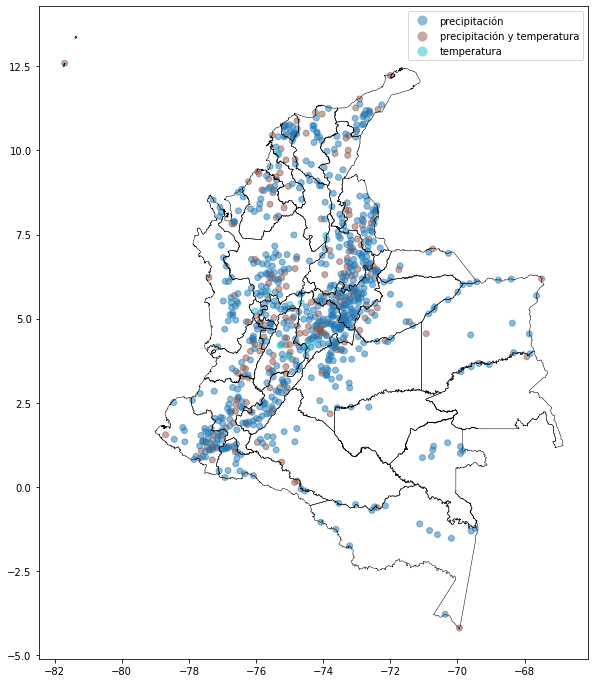

In [8]:
#axis = shp_depto_4326.plot(figsize = (20, 12))
axis = shp_depto_4326["perimetro"].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
shp_join_gdf.plot(ax = axis, column = 'met', alpha = 0.5, legend = True) 

In [9]:
shp_join_gdf = shp_join_gdf.set_index("DeNombre")
shp_depto_4326 = shp_depto_4326.set_index("DeNombre")

In [10]:
shp_mun = gpd.read_file('Municipios202208_shp/Munpio.shp') 
shp_mun_4326 = shp_mun.to_crs("EPSG:4326")
shp_mun_4326["perimetro"] = shp_mun_4326.boundary
#shp_mun_4326 = shp_mun_4326.set_index("DeNombre")

In [11]:
Cundi = shp_mun_4326.query("Depto == 'Cundinamarca'")
Cundi_stations = shp_join_gdf.loc["Cundinamarca", ["geometry", "met"]]

<AxesSubplot: >

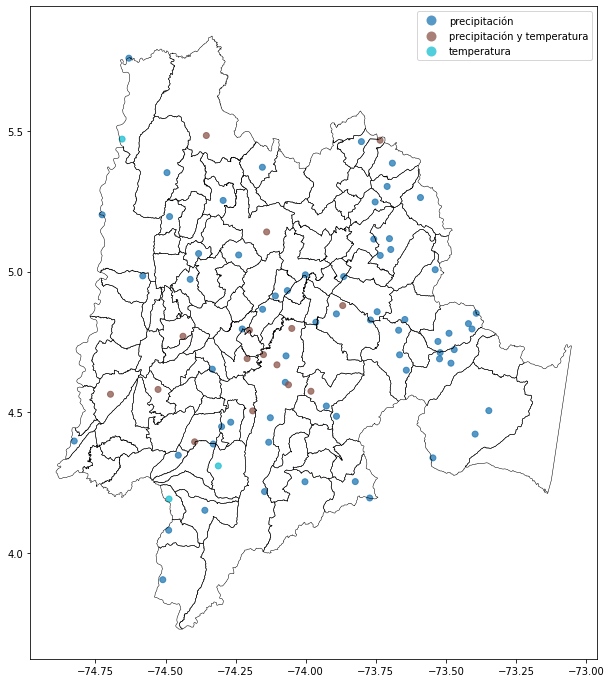

In [12]:
axis = Cundi['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
Cundi_stations.plot(ax = axis, alpha = 0.75, column = 'met', legend = True)

In [13]:
SAyP = shp_mun_4326.query("Depto == 'San Andrés y Providencia'")
#SAyP_stations = shp_join_pcp.loc["San Andrés Providencia y Santa Catalina", "geometry"]
SAyP_stations = gpd.GeoDataFrame(shp_join_gdf.query("DeCodigo == '88'"), geometry='geometry', crs = 'epsg:4326')

<AxesSubplot: >

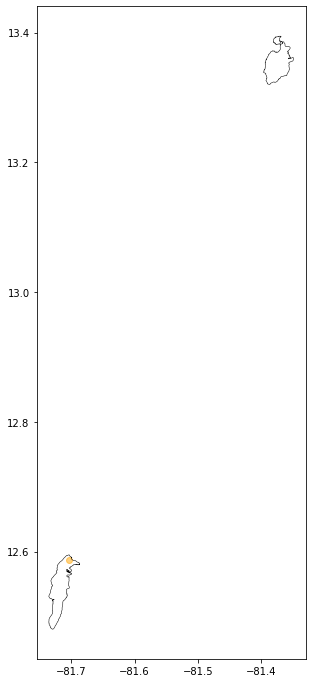

In [14]:
axis = SAyP['perimetro'].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
SAyP_stations.plot(ax = axis, alpha = 0.5, color = 'orange', legend = True)